In [183]:
import numpy as np
import astropy.units as u
import astropy.constants as cr
import matplotlib
import matplotlib.pyplot as plt
from astropy.modeling import models
from astropy.modeling.blackbody import FLAM

font = {'size' : 14, 'family' : 'sans-serif'}
matplotlib.rc('font', **font)

band = 'fuv'

# Set some telescope details
epd = 75 * u.cm
area = np.pi * (0.5*epd)**2
reflectivity = 0.9
mirrors = 3
dichroic = 0.5
qe = 0.5 * u.electron / u.ph

if band == 'fuv':
    band_wav = [120, 180]*u.nm
    sky_bgd_rate = 0.006 * u.ph / u.s # per pixel
elif band == 'nuv':
    band_wav = [180, 280]*u.nm
    sky_bgd_rate = 0.28 * u.ph / u.s # per pixel

# Set some detector details
psf_pix = 4
dark_current = 0.01 * u.electron / u.s
gain = 1.2 * u.adu / u.electron
saturation = 25000 * u.adu


In [268]:
# Input magnitude to photon flux
wav = np.arange(1000,9000) * u.AA # Wavelength scale in 1 Angstrom steps
dw = 1*u.AA
ph_energy = (cr.h.cgs * cr.c.cgs / wav.cgs) / u.ph

mags = np.arange(10,26,0.1) * u.ABmag

# Convert to FLAM units
cr_psf = np.zeros(len(mags)) * u.ph / u.s
for i, m in enumerate(mags):
    flux_den = m.to(FLAM, equivalencies=u.spectral_density(wav))
    ph_flux = flux_den * dw / ph_energy

    # In-band rate
    fluence = ph_flux[(wav >= band_wav[0].to(u.AA)) & (wav <= band_wav[1].to(u.AA))].sum()
    rate = fluence * area * (reflectivity**mirrors) * dichroic

    cr_psf[i] = rate
# PSF spread over four pixels
cr_pixel = cr_psf / psf_pix

In [269]:
def get_snr(exp_time, cr_pix):
    # Get a list of SNR arrays for each exposure time given
    
    snr = []
    for t in exp_time:
        # Input photon flux to electrons for given exposure time
        signal = cr_pix * qe * t

        # Handle saturation - this will make SNR 0 when saturated
        signal[signal > (saturation / gain)] = 0 * u.electron

        # Get background rate
        bgd_signal = sky_bgd_rate * qe * t + dark_current * t

        # Noise
        read_noise = 2 * u.electron
        shot_noise = np.sqrt(signal.value + bgd_signal.value) * u.electron # Quantum yield term will come in here

        # Get snr
        snr.append(signal / np.sqrt(shot_noise**2 + read_noise**2)) # Also add Fano noise in quad with these 
    
    return np.array(snr)

def perform_hdr(snr):
    # Pass array of two SNR curves, and pick the unsaturated values
    hdr_snr = np.where(snr[1] > 0, snr[1], snr[0])
    
    return hdr_snr
    

In [270]:
# Define exposure times
exp_time = [5.,300.] * u.s
labels = [str(t) for t in exp_time]
    
# Perform HDR algorithm
snr = get_snr(exp_time, cr_pixel)
hdr_snr = perform_hdr(snr)

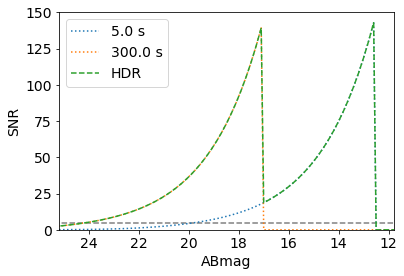

In [271]:
# Plot input magnitude vs SNR
plt.figure()
plt.hlines(5,11.5,25.5,color='grey',ls='--')
for i, t in enumerate(exp_time):
    plt.plot(mags,snr[i],ls='dotted',label=labels[i])
plt.plot(mags,hdr_snr,ls='--',label='HDR')
plt.legend()
plt.xlabel('ABmag')
plt.ylabel('SNR')
plt.xlim([25.2,11.8])
plt.ylim([0,150])
plt.show()

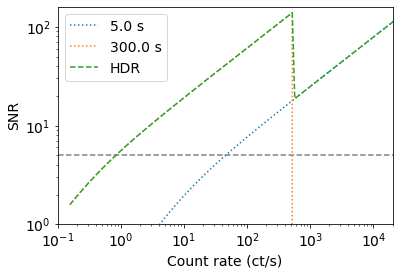

In [272]:
# Plot input count rate vs SNR
plt.figure()
plt.loglog()
plt.hlines(5,0.1,20000,color='grey',ls='--')
for i, t in enumerate(exp_time):
    plt.plot(cr_psf,snr[i],ls='dotted',label=labels[i])
plt.plot(cr_psf,hdr_snr,ls='--',label='HDR')
plt.legend()
plt.xlabel('Count rate (ct/s)')
plt.ylabel('SNR')
plt.xlim([0.1,20000])
plt.ylim([1,160])
plt.show()

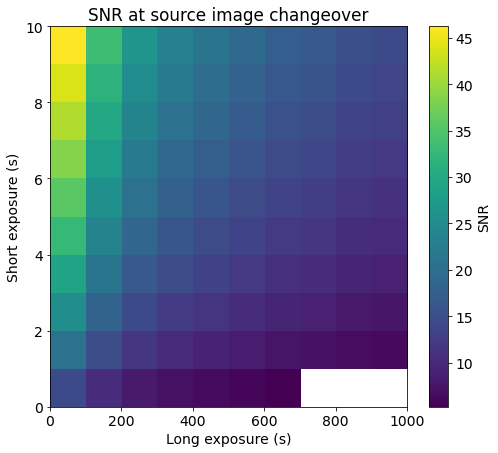

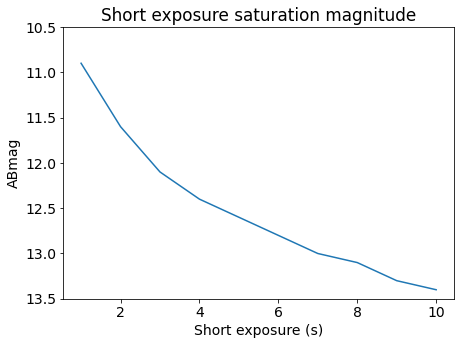

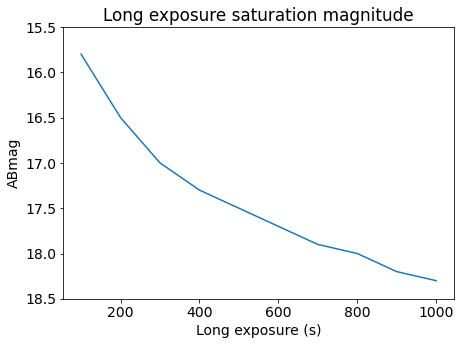

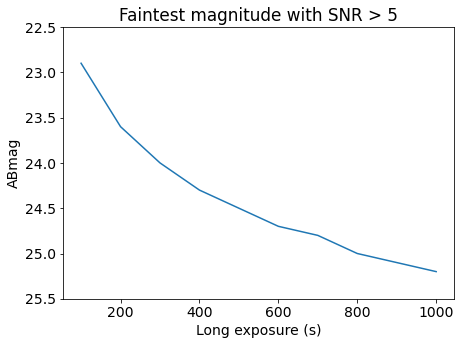

In [287]:
# Long exp
long_exp = [100,200,300,400,500,600,700,800,900,1000] * u.s
short_exp = [1,2,3,4,5,6,7,8,9,10] * u.s

min_snr_arr = np.zeros((len(long_exp),len(short_exp)))
min_snr_mag = np.zeros((len(long_exp),len(short_exp)))
faintest_mag = np.zeros(len(long_exp))
brightest_mag = np.zeros(len(short_exp))                   
for i, l in enumerate(long_exp):
    for j, s in enumerate(short_exp):
        snr = get_snr([s,l], cr_pixel)
        hdr_snr = perform_hdr(snr)
        
        h = hdr_snr[0]
        discont_index = -1
        for k, hs in enumerate(hdr_snr):
            
            # Get brightest magnitude
            if (hs > 0) & (brightest_mag[j] == 0):
                brightest_mag[j] = mags[k].value
            
            # Find the SNR discontinuity
            if (hs > h) & (h > 0):
                snr_jump = h
                discont_index = k-1
                h = 0
            elif(discont_index < 0):
                h = hs
                
            # Get faintest magnitude with SNR > 5, not counting saturation
            # Don't set unless we've already set discontinuity
            if (hs < 5) & (hs > 0) & (faintest_mag[i] == 0) & (h == 0):
                faintest_mag[i] = mags[k-1].value
        
        min_snr_arr[j,i] = snr_jump
        min_snr_mag[j,i] = mags[discont_index].value
        
min_snr_arr[min_snr_arr < 5] = np.nan
        
plt.figure(figsize=[8,7])
plt.title('SNR at source image changeover')
plt.imshow(min_snr_arr,origin='lower',extent=[0,1000,0,10],aspect='auto')
plt.xlabel('Long exposure (s)')
plt.ylabel('Short exposure (s)')
plt.colorbar(label='SNR')
plt.show()

plt.figure(figsize=[7,5])
plt.title('Short exposure saturation magnitude')
plt.plot(short_exp,brightest_mag)
plt.xlabel('Short exposure (s)')
plt.ylabel('ABmag')
plt.ylim([13.5,10.5])
plt.show()

plt.figure(figsize=[7,5])
plt.title('Long exposure saturation magnitude')
plt.plot(long_exp,min_snr_mag[0,:])
plt.xlabel('Long exposure (s)')
plt.ylabel('ABmag')
plt.ylim([18.5,15.5])
plt.show()

plt.figure(figsize=[7,5])
plt.title('Faintest magnitude with SNR > 5')
plt.plot(long_exp,faintest_mag)
plt.xlabel('Long exposure (s)')
plt.ylabel('ABmag')
plt.ylim([25.5,22.5])
plt.show()